In [87]:
import numpy as np
import pylab as pl
from scipy.optimize import least_squares as lsmin

### Microstructure parameters of the test voxel

Diffusivities:  
$D_{csf} = 3\,\frac{\mu \text{m}^2}{m\text{s}}$  
$D_{WM}^{\parallel} = 1.5\,\frac{\mu \text{m}^2}{m\text{s}}$  
$D_{WM}^{\perp} = 0.3\,\frac{\mu \text{m}^2}{m\text{s}}$

Relaxation times:  
$T^{csf}_2 = 2000\,m\text{s}$  
$T^{WM}_2 = 80\,m\text{s}$

Volume fractions:  
$f_{WM} = 0.7$  
$f_{csf} = 1- f_{WM} = 0.3$

In [88]:
# Microstructure parameters
Dcsf = 3
Dwmpara = 1.5
Dwmperp = 0.3
T2csf = 2000
T2wm = 80
fwm = 0.7
fcsf = 1-fwm

### 2-compartements signal generation formula.  
$S(b, \text{TE}) = f_{WM}*S_{WM}(b, \text{TE}) + (1-f_{WM})*S_{csf}(b, \text{TE})$  
$S_{csf}(b, \text{TE}) = \exp(-\frac{\text{TE}}{T^{csf}_2})*\exp(-b D_{csf})$  
$S_{WM}(b, \text{TE}) = \exp(-\frac{\text{TE}}{T^{WM}_2})*\exp(-b D_{WM})$  
Note: $D_{WM} \in [D_{WM}^{\perp} D_{WM}^{\parallel}]$ depending on the unspecified acquisition directions.  
Note2: Technically all signal formulas are premultiplied by some $S_{something}$ term containing the non-diffusion non-T2 contrast but its assumed constant across tissues and therefore we can omit it (same as setting it to 1 or assumeing everything is normalized by it)

In [89]:
# diffusion attenuation
def diff(b, D):
    return np.exp(-b*D)

In [90]:
# T2 attenuation
def trans(TE, T2):
    return np.exp(-TE/T2)

In [91]:
# T2 and diff attenuation
def att(b, D, TE, T2):
    return diff(b, D) * trans(TE, T2)

In [92]:
# 2 compartment model (in 1D)
def S_2comp(b, TE, f1, D1, D2, T2_1, T2_2):
    S1 = att(b, D1, TE, T2_1)
    S2 = att(b, D2, TE, T2_2)
    return f1*S1+(1-f1)*S2

In [93]:
# apparant volume fraction (or signal fraction) for comp1 in 2-comp model
def sf1(TE, T2_1, T2_2, f1):
    tmp1 = f1*trans(TE, T2_1)
    tmp2 = (1-f1)*trans(TE, T2_2)
    return tmp1 / (tmp1+tmp2)

### Acquisition parameter
TE = 79 ms  
total number of volume (incl. b0s) = 232

In [94]:
TE = 79 # ms
nVol = 232 # incl. b0s
voxsize = 1.3 # isotropic

### Decay curves for each tissue

In [95]:
bs = np.linspace(0, 2, 100, endpoint=True)

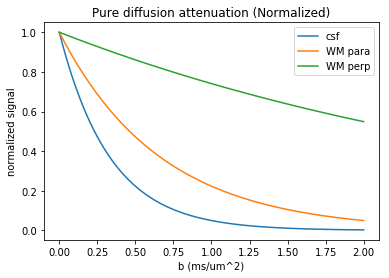

In [96]:
pl.figure()
pl.plot(bs, diff(bs, Dcsf), label='csf')
pl.plot(bs, diff(bs, Dwmpara), label='WM para')
pl.plot(bs, diff(bs, Dwmperp), label='WM perp')
pl.legend()
pl.xlabel('b (ms/um^2)')
pl.ylabel('normalized signal')
pl.title('Pure diffusion attenuation (Normalized)')
pl.show()

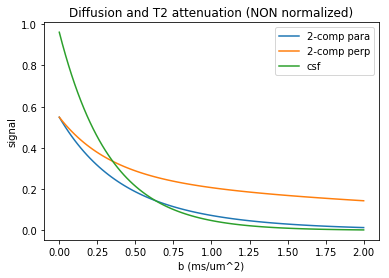

In [97]:
pl.figure()
pl.plot(bs, S_2comp(bs, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf), label='2-comp para')
pl.plot(bs, S_2comp(bs, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf), label='2-comp perp')
pl.plot(bs, att(bs, Dcsf, TE, T2csf), label='csf')
# pl.plot(bs, att(bs, Dwmpara, TE, T2wm), label='WM para')
# pl.plot(bs, att(bs, Dwmperp, TE, T2wm), label='WM perp')
pl.legend()
pl.xlabel('b (ms/um^2)')
pl.ylabel('signal')
pl.title('Diffusion and T2 attenuation (NON normalized)')
pl.show()

In [98]:
# mean diffusivity (MD) (for WM compartement)
def MD(Dpara, Dperp):
    return (Dpara + 2*Dperp)/3

In [99]:
WM_MD = MD(Dwmpara, Dwmperp)
print(WM_MD)

0.7000000000000001


In [100]:
# fractional anisotropy (FA) (for WM compartement)
def FA(Dpara, Dperp):
    Dmean = MD(Dpara, Dperp)
    return ((3/2.)*((Dpara-Dmean)**2 + 2*(Dperp-Dmean)**2)/(Dpara**2+2*Dperp**2))**(0.5)

In [101]:
WM_FA = FA(Dwmpara, Dwmperp)
print(WM_FA)

0.769800358919501


In [102]:
# since sigma is from background, its underestimating the center
sigmas = [71, 75.5]
b0_CC = [1500, 2000]
b0_ventr = [7000, 9000]
for i1 in range(len(sigmas)):
    sigma = sigmas[i1]
    for i2 in range(len(b0_CC)):
        s_CC = b0_CC[i2]
        s_ventr = b0_ventr[i2]
        s_ = fwm*s_CC + fcsf*s_ventr
        print('{:.2f} {:.2f} {:.2f}'.format(s_CC/sigma, s_ventr/sigma, s_/sigma))
        
# random 6vox roi in ventricule on the MC b0s gives
# means [7103.52601207, 7152.96877219, 7099.1969771, 7311.45177113, 7373.67120916, 7325.45778587]
# std  [340.86897669, 426.64685756, 381.74317104, 329.15869363, 327.81481975, 369.86381322]
# snr [20.83946178, 16.76554894, 18.59678841, 22.21254341, 22.4934041 ,19.80582453]
# g-factor of 5?? seems too much

21.13 98.59 44.37
28.17 126.76 57.75
19.87 92.72 41.72
26.49 119.21 54.30


### SNR estimation
As a rule of thumb we have $SNR = 20$ at the b0, in WM, for 1.3 mm isotropic (for EACH volume)  
i.e. $S = S_{\text{\{not diffusion, not T2\}}} * \exp(-\frac{\text{TE}}{T^{WM}_2}) + \epsilon$ where $\epsilon \sim N(0, sigma),\, sigma = \frac{S_{\text{not diffusion, not T2}} * \exp(-\frac{\text{TE}}{T^{WM}_2})}{30}$  
We assumes $S_{\text{\{not diffusion, not T2\}}} = 1$ for all tissues and we can compute sigma and directly use it to add realistic noise level without messing with normalization

In [103]:
# Realistic single-volume sigma from WM rule of thumb
baselinevox = 1.3
baselineSNR_WM = 20
sigma = (baselinevox**3 / voxsize**3) * trans(TE, T2wm)/baselineSNR_WM
print('sigma = {:.4f} per volume (at b0, 2mm iso)'.format(sigma))
# equivalence for pure WM and pure CSF
print('This is equivalent to SNR = {:.1f} in pure csf'.format(trans(TE, T2csf)/sigma))
print('This is equivalent to SNR = {:.1f} in pure wm'.format(trans(TE, T2wm)/sigma))
print('This is equivalent to SNR = {:.1f} in our 2-comp voxel'.format(S_2comp(0, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)/sigma))

sigma = 0.0186 per volume (at b0, 2mm iso)
This is equivalent to SNR = 51.6 in pure csf
This is equivalent to SNR = 20.0 in pure wm
This is equivalent to SNR = 29.5 in our 2-comp voxel


### Inclusion of number of volume into SNR
We only simulate 2 directions here, perfectly parallel and perfectly perpendicular  
To incorporate number of volumes, we will simply distribute them across the different bvalues and increase SNR as if they were averages.  
For each non-zero b-value there will be equal amount of parallel and perpendicular volumes.

In [104]:
# compute the per shell per "direction" sigmas
def compute_sigmas(basesigma, Naverages, Ndir):
    return basesigma/np.sqrt(Naverages/Ndir)

In [105]:
# example
basesigma = 0.0186
Naverages = np.array([22, 30, 180])
Ndir = np.array([1, 2, 2])
print(compute_sigmas(basesigma, Naverages, Ndir))

[0.00396553 0.0048025  0.00196061]


# Now we simulate
We simulate data and compute distribution over MD and FA for various strategy and sampling scheme

In [106]:
# noise repetitions
Ntrial = 1000

In [107]:
# will log bias and std for MD and FA for each strategy / bval choice
strat = []
MD_bias = []
FA_bias = []
MD_std = []
FA_std = []

### case 0: no-partial voluming to get BASELINE variance on the parameters

Modified microstructure with $f_{WM} = 1$  
We simulate the signal for 22 b0 and 210 b1  
We compute $D_{\parallel}$ and $D_{\perp}$ directly on the b0 normalized signal

In [108]:
# compute effective sigma
effective_sigma = compute_sigmas(sigma, np.array([22, 210]), np.array([1, 2]))
print(effective_sigma)

[0.00397094 0.00181765]


In [109]:
# noiseless signal generation
bval = 1.0
S0 = S_2comp(0, TE, 1, Dwmpara, Dcsf, T2wm, T2csf)
S1_para = S_2comp(bval, TE, 1, Dwmpara, Dcsf, T2wm, T2csf)
S1_perp = S_2comp(bval, TE, 1, Dwmperp, Dcsf, T2wm, T2csf)

In [110]:
# noise repetition
MDs = []
FAs = []
for i in range(Ntrial):
    # add noise with the right sigma
    S0_noisy = S0 + effective_sigma[0]*np.random.randn()
    S1_para_noisy = S1_para + effective_sigma[1]*np.random.randn()
    S1_perp_noisy = S1_perp + effective_sigma[1]*np.random.randn()
    
    # estimate Diff
    D_para_est = np.log(S1_para_noisy/S0_noisy)/(-bval)
    D_perp_est = np.log(S1_perp_noisy/S0_noisy)/(-bval)
    
    # compute metrics
    MD_est = MD(D_para_est, D_perp_est)
    FA_est = FA(D_para_est, D_perp_est)
    
    # log values
    MDs.append(MD_est)
    FAs.append(FA_est)
    
MDs = np.array(MDs)
FAs = np.array(FAs)

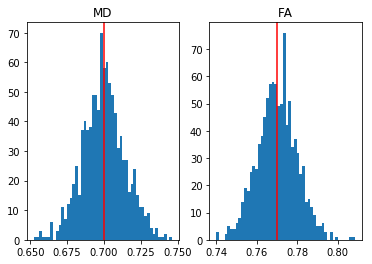

In [111]:
pl.figure()
pl.subplot(1,2,1)
pl.hist(MDs, 50)
pl.axvline(WM_MD, c='red')
pl.title('MD')
pl.subplot(1,2,2)
pl.hist(FAs, 50)
pl.axvline(WM_FA, c='red')
pl.title('FA')
pl.show()

In [112]:
strat.append('Baseline without csf (b1)')
MD_bias.append(WM_MD - MDs.mean())
FA_bias.append(WM_FA - FAs.mean())
MD_std.append(MDs.std())
FA_std.append(FAs.std())

### case 1: When we completely ignore the partial-voluming

Signal from 2-comp model   
We simulate the signal for 22 b0 and 210 b1  
We compute $D_{\parallel}$ and $D_{\perp}$ directly on the b0 normalized signal as if there was no partial voluming

In [113]:
# compute effective sigma
effective_sigma = compute_sigmas(sigma, np.array([22, 210]), np.array([1, 2]))
print(effective_sigma)

[0.00397094 0.00181765]


In [114]:
# noiseless signal generation
bval = 1.0
S0 = S_2comp(0, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_para = S_2comp(bval, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_perp = S_2comp(bval, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)

In [115]:
# noise repetition
MDs = []
FAs = []
for i in range(Ntrial):
    # add noise with the right sigma
    S0_noisy = S0 + effective_sigma[0]*np.random.randn()
    S1_para_noisy = S1_para + effective_sigma[1]*np.random.randn()
    S1_perp_noisy = S1_perp + effective_sigma[1]*np.random.randn()
    
    # estimate Diff
    D_para_est = np.log(S1_para_noisy/S0_noisy)/(-bval)
    D_perp_est = np.log(S1_perp_noisy/S0_noisy)/(-bval)
    
    # compute metrics
    MD_est = MD(D_para_est, D_perp_est)
    FA_est = FA(D_para_est, D_perp_est)
    
    # log values
    MDs.append(MD_est)
    FAs.append(FA_est)
    
MDs = np.array(MDs)
FAs = np.array(FAs)

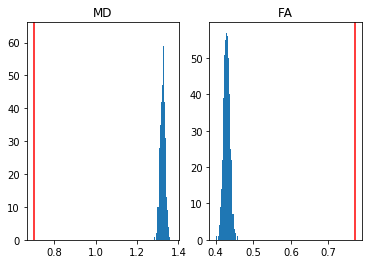

In [116]:
pl.figure()
pl.subplot(1,2,1)
pl.hist(MDs, 50)
pl.axvline(WM_MD, c='red')
pl.title('MD')
pl.subplot(1,2,2)
pl.hist(FAs, 50)
pl.axvline(WM_FA, c='red')
pl.title('FA')
pl.show()

In [117]:
strat.append('ignore csf (b1)')
MD_bias.append(WM_MD - MDs.mean())
FA_bias.append(WM_FA - FAs.mean())
MD_std.append(MDs.std())
FA_std.append(FAs.std())

### case 2: We use 2 non-zero b and assume $S_{csf}$ is fully attenuated

Signal from 2-comp model   
We simulate the signal for 52 $b_{low}$ and 180 $b_{high}$  
We compute $D_{\parallel}$ and $D_{\perp}$ directly on the ratio signal as if there was no partial voluming anymore

In [118]:
# compute effective sigma
effective_sigma = compute_sigmas(sigma, np.array([52, 180]), np.array([2, 2]))
print(effective_sigma)

[0.00365273 0.00196328]


### 2.1   bval = (0.5 1.0)

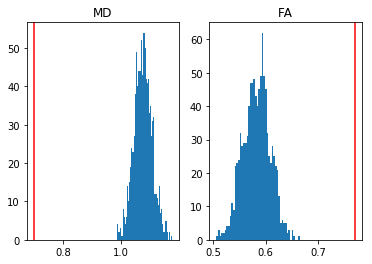

In [119]:
# noiseless signal generation
bval1 = 0.5
bval2 = 1.0
S1_para = S_2comp(bval1, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_perp = S_2comp(bval1, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
S2_para = S_2comp(bval2, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S2_perp = S_2comp(bval2, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)

# noise repetition
MDs = []
FAs = []
for i in range(Ntrial):
    # add noise with the right sigma
    S1_para_noisy = S1_para + effective_sigma[0]*np.random.randn()
    S1_perp_noisy = S1_perp + effective_sigma[0]*np.random.randn()
    S2_para_noisy = S2_para + effective_sigma[1]*np.random.randn()
    S2_perp_noisy = S2_perp + effective_sigma[1]*np.random.randn()    
    
    # estimate Diff
    D_para_est = np.log(S2_para_noisy/S1_para_noisy)/(bval1-bval2)
    D_perp_est = np.log(S2_perp_noisy/S1_perp_noisy)/(bval1-bval2)
    
    # compute metrics
    MD_est = MD(D_para_est, D_perp_est)
    FA_est = FA(D_para_est, D_perp_est)
    
    # log values
    MDs.append(MD_est)
    FAs.append(FA_est)
    
MDs = np.array(MDs)
FAs = np.array(FAs)

pl.figure()
pl.subplot(1,2,1)
pl.hist(MDs, 50)
pl.axvline(WM_MD, c='red')
pl.title('MD')
pl.subplot(1,2,2)
pl.hist(FAs, 50)
pl.axvline(WM_FA, c='red')
pl.title('FA')
pl.show()

In [120]:
strat.append('assume attenuated csf (b 0.5 1.0)')
MD_bias.append(WM_MD - MDs.mean())
FA_bias.append(WM_FA - FAs.mean())
MD_std.append(MDs.std())
FA_std.append(FAs.std())

### 2.2   bval = (0.5 1.5)

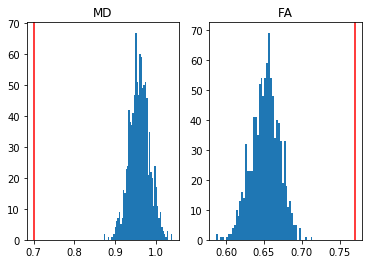

In [121]:
# noiseless signal generation
bval1 = 0.5
bval2 = 1.5
S1_para = S_2comp(bval1, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_perp = S_2comp(bval1, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
S2_para = S_2comp(bval2, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S2_perp = S_2comp(bval2, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)

# noise repetition
MDs = []
FAs = []
for i in range(Ntrial):
    # add noise with the right sigma
    S1_para_noisy = S1_para + effective_sigma[0]*np.random.randn()
    S1_perp_noisy = S1_perp + effective_sigma[0]*np.random.randn()
    S2_para_noisy = S2_para + effective_sigma[1]*np.random.randn()
    S2_perp_noisy = S2_perp + effective_sigma[1]*np.random.randn()    
    
    # estimate Diff
    D_para_est = np.log(S2_para_noisy/S1_para_noisy)/(bval1-bval2)
    D_perp_est = np.log(S2_perp_noisy/S1_perp_noisy)/(bval1-bval2)
    
    # compute metrics
    MD_est = MD(D_para_est, D_perp_est)
    FA_est = FA(D_para_est, D_perp_est)
    
    # log values
    MDs.append(MD_est)
    FAs.append(FA_est)
    
MDs = np.array(MDs)
FAs = np.array(FAs)

pl.figure()
pl.subplot(1,2,1)
pl.hist(MDs, 50)
pl.axvline(WM_MD, c='red')
pl.title('MD')
pl.subplot(1,2,2)
pl.hist(FAs, 50)
pl.axvline(WM_FA, c='red')
pl.title('FA')
pl.show()

In [122]:
strat.append('assume attenuated csf (b 0.5 1.5)')
MD_bias.append(WM_MD - MDs.mean())
FA_bias.append(WM_FA - FAs.mean())
MD_std.append(MDs.std())
FA_std.append(FAs.std())

### 2.3   bval = (0.75 1.5)

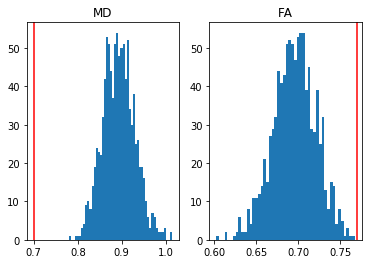

In [123]:
# noiseless signal generation
bval1 = 0.75
bval2 = 1.5
S1_para = S_2comp(bval1, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_perp = S_2comp(bval1, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
S2_para = S_2comp(bval2, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S2_perp = S_2comp(bval2, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)

# noise repetition
MDs = []
FAs = []
for i in range(Ntrial):
    # add noise with the right sigma
    S1_para_noisy = S1_para + effective_sigma[0]*np.random.randn()
    S1_perp_noisy = S1_perp + effective_sigma[0]*np.random.randn()
    S2_para_noisy = S2_para + effective_sigma[1]*np.random.randn()
    S2_perp_noisy = S2_perp + effective_sigma[1]*np.random.randn()    
    
    # estimate Diff
    D_para_est = np.log(S2_para_noisy/S1_para_noisy)/(bval1-bval2)
    D_perp_est = np.log(S2_perp_noisy/S1_perp_noisy)/(bval1-bval2)
    
    # compute metrics
    MD_est = MD(D_para_est, D_perp_est)
    FA_est = FA(D_para_est, D_perp_est)
    
    # log values
    MDs.append(MD_est)
    FAs.append(FA_est)
    
MDs = np.array(MDs)
FAs = np.array(FAs)

pl.figure()
pl.subplot(1,2,1)
pl.hist(MDs, 50)
pl.axvline(WM_MD, c='red')
pl.title('MD')
pl.subplot(1,2,2)
pl.hist(FAs, 50)
pl.axvline(WM_FA, c='red')
pl.title('FA')
pl.show()

In [124]:
strat.append('assume attenuated csf (b 0.75 1.5)')
MD_bias.append(WM_MD - MDs.mean())
FA_bias.append(WM_FA - FAs.mean())
MD_std.append(MDs.std())
FA_std.append(FAs.std())

### 2.4   bval = (0.75 1.25)

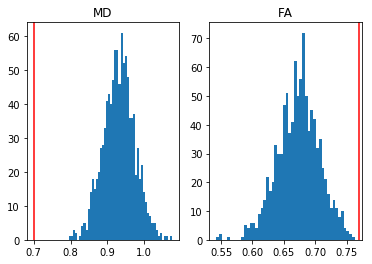

In [125]:
# noiseless signal generation
bval1 = 0.75
bval2 = 1.25
S1_para = S_2comp(bval1, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_perp = S_2comp(bval1, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
S2_para = S_2comp(bval2, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S2_perp = S_2comp(bval2, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)

# noise repetition
MDs = []
FAs = []
for i in range(Ntrial):
    # add noise with the right sigma
    S1_para_noisy = S1_para + effective_sigma[0]*np.random.randn()
    S1_perp_noisy = S1_perp + effective_sigma[0]*np.random.randn()
    S2_para_noisy = S2_para + effective_sigma[1]*np.random.randn()
    S2_perp_noisy = S2_perp + effective_sigma[1]*np.random.randn()    
    
    # estimate Diff
    D_para_est = np.log(S2_para_noisy/S1_para_noisy)/(bval1-bval2)
    D_perp_est = np.log(S2_perp_noisy/S1_perp_noisy)/(bval1-bval2)
    
    # compute metrics
    MD_est = MD(D_para_est, D_perp_est)
    FA_est = FA(D_para_est, D_perp_est)
    
    # log values
    MDs.append(MD_est)
    FAs.append(FA_est)
    
MDs = np.array(MDs)
FAs = np.array(FAs)

pl.figure()
pl.subplot(1,2,1)
pl.hist(MDs, 50)
pl.axvline(WM_MD, c='red')
pl.title('MD')
pl.subplot(1,2,2)
pl.hist(FAs, 50)
pl.axvline(WM_FA, c='red')
pl.title('FA')
pl.show()

In [126]:
strat.append('assume attenuated csf (b 0.75 1.25)')
MD_bias.append(WM_MD - MDs.mean())
FA_bias.append(WM_FA - FAs.mean())
MD_std.append(MDs.std())
FA_std.append(FAs.std())

### case 3: Fitting 2-comp with 2 shell + b0

Signal from 2-comp model   
We simulate the signal for 22 b0 and 30 $b_{low}$ and 180 $b_{high}$   
We fit the 2-comp model on the 5 data point and use the Diffusivities from the WM compartement for metrics

In [127]:
# compute effective sigma
effective_sigma = compute_sigmas(sigma, np.array([22, 30, 180]), np.array([1, 2, 2]))
print(effective_sigma)

[0.00397094 0.00480904 0.00196328]


### 3.1   bval = (0, 0.5, 1.0)

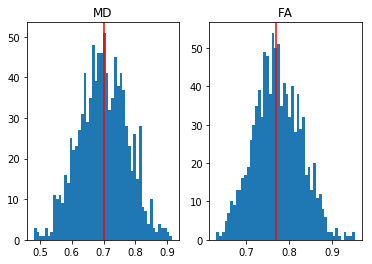

In [128]:
# noiseless signal generation
bval0 = 0
bval1 = 0.5
bval2 = 1.0
S0 = S_2comp(0, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_para = S_2comp(bval1, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_perp = S_2comp(bval1, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
S2_para = S_2comp(bval2, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S2_perp = S_2comp(bval2, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)

# optim init (S_other, sf_wm, D_para, D_perp)
x0 = np.array([0.75, 0.5, 1.0, 1.0])

# noise repetition
MDs = []
FAs = []
for i in range(Ntrial):
    # add noise with the right sigma
    S0_noisy = S0 + effective_sigma[0]*np.random.randn()
    S1_para_noisy = S1_para + effective_sigma[1]*np.random.randn()
    S1_perp_noisy = S1_perp + effective_sigma[1]*np.random.randn()
    S2_para_noisy = S2_para + effective_sigma[2]*np.random.randn()
    S2_perp_noisy = S2_perp + effective_sigma[2]*np.random.randn()    
    
    # estimate Diff
    data = np.array([S0_noisy, S1_para_noisy, S2_para_noisy, S1_perp_noisy, S2_perp_noisy])
                
    # error function
    def f(xdata):
        S0est, sf, Dpara, Dperp = xdata
        Swmpara = diff(np.array([0, bval1, bval2]), Dpara)
        Swmperp = diff(np.array([bval1, bval2]), Dperp)
        Swm = np.concatenate([Swmpara, Swmperp], axis=0)
        Scsf = diff(np.array([bval0, bval1, bval2, bval1, bval2]), Dcsf)
        S = S0est*(sf*Swm + (1-sf)*Scsf)
        return S - data

    sol = lsmin(f, x0, jac='2-point', bounds=((0, 0, 0, 0),(1, 1, 3, 3)), method='trf', ftol=1e-8, xtol=1e-8, gtol=1e-8, x_scale=1.0, loss='linear', f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, jac_sparsity=None, max_nfev=None, verbose=0, args=(), kwargs={})

    D_para_est = sol.x[2]
    D_perp_est = sol.x[3]
    
    # compute metrics
    MD_est = MD(D_para_est, D_perp_est)
    FA_est = FA(D_para_est, D_perp_est)
    
    # log values
    MDs.append(MD_est)
    FAs.append(FA_est)
    
MDs = np.array(MDs)
FAs = np.array(FAs)

pl.figure()
pl.subplot(1,2,1)
pl.hist(MDs, 50)
pl.axvline(WM_MD, c='red')
pl.title('MD')
pl.subplot(1,2,2)
pl.hist(FAs, 50)
pl.axvline(WM_FA, c='red')
pl.title('FA')
pl.show()

In [129]:
strat.append('fit 2-comp 2-shells (b 0 0.5 1.0)')
MD_bias.append(WM_MD - MDs.mean())
FA_bias.append(WM_FA - FAs.mean())
MD_std.append(MDs.std())
FA_std.append(FAs.std())

### 3.2   bval = (0, 0.5, 1.5)

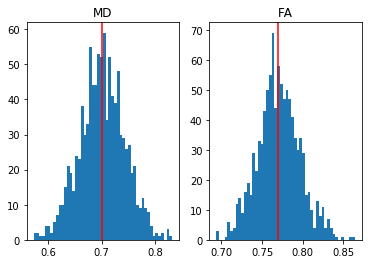

In [130]:
# noiseless signal generation
bval0 = 0
bval1 = 0.5
bval2 = 1.5
S0 = S_2comp(0, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_para = S_2comp(bval1, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_perp = S_2comp(bval1, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
S2_para = S_2comp(bval2, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S2_perp = S_2comp(bval2, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)

# optim init (S_other, sf_wm, D_para, D_perp)
x0 = np.array([0.75, 0.5, 1.0, 1.0])

# noise repetition
MDs = []
FAs = []
for i in range(Ntrial):
    # add noise with the right sigma
    S0_noisy = S0 + effective_sigma[0]*np.random.randn()
    S1_para_noisy = S1_para + effective_sigma[1]*np.random.randn()
    S1_perp_noisy = S1_perp + effective_sigma[1]*np.random.randn()
    S2_para_noisy = S2_para + effective_sigma[2]*np.random.randn()
    S2_perp_noisy = S2_perp + effective_sigma[2]*np.random.randn()    
    
    # estimate Diff
    data = np.array([S0_noisy, S1_para_noisy, S2_para_noisy, S1_perp_noisy, S2_perp_noisy])
                
    # error function
    def f(xdata):
        S0est, sf, Dpara, Dperp = xdata
        Swmpara = diff(np.array([0, bval1, bval2]), Dpara)
        Swmperp = diff(np.array([bval1, bval2]), Dperp)
        Swm = np.concatenate([Swmpara, Swmperp], axis=0)
        Scsf = diff(np.array([bval0, bval1, bval2, bval1, bval2]), Dcsf)
        S = S0est*(sf*Swm + (1-sf)*Scsf)
        return S - data

    sol = lsmin(f, x0, jac='2-point', bounds=((0, 0, 0, 0),(1, 1, 3, 3)), method='trf', ftol=1e-8, xtol=1e-8, gtol=1e-8, x_scale=1.0, loss='linear', f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, jac_sparsity=None, max_nfev=None, verbose=0, args=(), kwargs={})

    D_para_est = sol.x[2]
    D_perp_est = sol.x[3]
    
    # compute metrics
    MD_est = MD(D_para_est, D_perp_est)
    FA_est = FA(D_para_est, D_perp_est)
    
    # log values
    MDs.append(MD_est)
    FAs.append(FA_est)
    
MDs = np.array(MDs)
FAs = np.array(FAs)

pl.figure()
pl.subplot(1,2,1)
pl.hist(MDs, 50)
pl.axvline(WM_MD, c='red')
pl.title('MD')
pl.subplot(1,2,2)
pl.hist(FAs, 50)
pl.axvline(WM_FA, c='red')
pl.title('FA')
pl.show()

In [131]:
strat.append('fit 2-comp 2-shells (b 0 0.5 1.5)')
MD_bias.append(WM_MD - MDs.mean())
FA_bias.append(WM_FA - FAs.mean())
MD_std.append(MDs.std())
FA_std.append(FAs.std())

### 3.3   bval = (0, 0.75, 1.5)

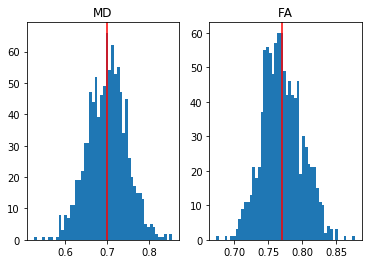

In [132]:
# noiseless signal generation
bval0 = 0
bval1 = 0.75
bval2 = 1.5
S0 = S_2comp(0, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_para = S_2comp(bval1, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_perp = S_2comp(bval1, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
S2_para = S_2comp(bval2, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S2_perp = S_2comp(bval2, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)

# optim init (S_other, sf_wm, D_para, D_perp)
x0 = np.array([0.75, 0.5, 1.0, 1.0])

# noise repetition
MDs = []
FAs = []
for i in range(Ntrial):
    # add noise with the right sigma
    S0_noisy = S0 + effective_sigma[0]*np.random.randn()
    S1_para_noisy = S1_para + effective_sigma[1]*np.random.randn()
    S1_perp_noisy = S1_perp + effective_sigma[1]*np.random.randn()
    S2_para_noisy = S2_para + effective_sigma[2]*np.random.randn()
    S2_perp_noisy = S2_perp + effective_sigma[2]*np.random.randn()    
    
    # estimate Diff
    data = np.array([S0_noisy, S1_para_noisy, S2_para_noisy, S1_perp_noisy, S2_perp_noisy])
                
    # error function
    def f(xdata):
        S0est, sf, Dpara, Dperp = xdata
        Swmpara = diff(np.array([0, bval1, bval2]), Dpara)
        Swmperp = diff(np.array([bval1, bval2]), Dperp)
        Swm = np.concatenate([Swmpara, Swmperp], axis=0)
        Scsf = diff(np.array([bval0, bval1, bval2, bval1, bval2]), Dcsf)
        S = S0est*(sf*Swm + (1-sf)*Scsf)
        return S - data

    sol = lsmin(f, x0, jac='2-point', bounds=((0, 0, 0, 0),(1, 1, 3, 3)), method='trf', ftol=1e-8, xtol=1e-8, gtol=1e-8, x_scale=1.0, loss='linear', f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, jac_sparsity=None, max_nfev=None, verbose=0, args=(), kwargs={})

    D_para_est = sol.x[2]
    D_perp_est = sol.x[3]
    
    # compute metrics
    MD_est = MD(D_para_est, D_perp_est)
    FA_est = FA(D_para_est, D_perp_est)
    
    # log values
    MDs.append(MD_est)
    FAs.append(FA_est)
    
MDs = np.array(MDs)
FAs = np.array(FAs)

pl.figure()
pl.subplot(1,2,1)
pl.hist(MDs, 50)
pl.axvline(WM_MD, c='red')
pl.title('MD')
pl.subplot(1,2,2)
pl.hist(FAs, 50)
pl.axvline(WM_FA, c='red')
pl.title('FA')
pl.show()

In [133]:
strat.append('fit 2-comp 2-shells (b 0 0.75 1.0)')
MD_bias.append(WM_MD - MDs.mean())
FA_bias.append(WM_FA - FAs.mean())
MD_std.append(MDs.std())
FA_std.append(FAs.std())

### 3.4   bval = (0, 0.3, 1.0)

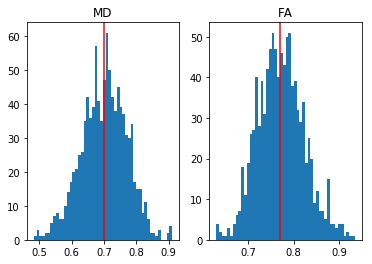

In [134]:
# noiseless signal generation
bval0 = 0
bval1 = 0.3
bval2 = 1.0
S0 = S_2comp(0, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_para = S_2comp(bval1, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_perp = S_2comp(bval1, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
S2_para = S_2comp(bval2, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S2_perp = S_2comp(bval2, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)

# optim init (S_other, sf_wm, D_para, D_perp)
x0 = np.array([0.75, 0.5, 1.0, 1.0])

# noise repetition
MDs = []
FAs = []
for i in range(Ntrial):
    # add noise with the right sigma
    S0_noisy = S0 + effective_sigma[0]*np.random.randn()
    S1_para_noisy = S1_para + effective_sigma[1]*np.random.randn()
    S1_perp_noisy = S1_perp + effective_sigma[1]*np.random.randn()
    S2_para_noisy = S2_para + effective_sigma[2]*np.random.randn()
    S2_perp_noisy = S2_perp + effective_sigma[2]*np.random.randn()    
    
    # estimate Diff
    data = np.array([S0_noisy, S1_para_noisy, S2_para_noisy, S1_perp_noisy, S2_perp_noisy])
                
    # error function
    def f(xdata):
        S0est, sf, Dpara, Dperp = xdata
        Swmpara = diff(np.array([0, bval1, bval2]), Dpara)
        Swmperp = diff(np.array([bval1, bval2]), Dperp)
        Swm = np.concatenate([Swmpara, Swmperp], axis=0)
        Scsf = diff(np.array([bval0, bval1, bval2, bval1, bval2]), Dcsf)
        S = S0est*(sf*Swm + (1-sf)*Scsf)
        return S - data

    sol = lsmin(f, x0, jac='2-point', bounds=((0, 0, 0, 0),(1, 1, 3, 3)), method='trf', ftol=1e-8, xtol=1e-8, gtol=1e-8, x_scale=1.0, loss='linear', f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, jac_sparsity=None, max_nfev=None, verbose=0, args=(), kwargs={})

    D_para_est = sol.x[2]
    D_perp_est = sol.x[3]
    
    # compute metrics
    MD_est = MD(D_para_est, D_perp_est)
    FA_est = FA(D_para_est, D_perp_est)
    
    # log values
    MDs.append(MD_est)
    FAs.append(FA_est)
    
MDs = np.array(MDs)
FAs = np.array(FAs)

pl.figure()
pl.subplot(1,2,1)
pl.hist(MDs, 50)
pl.axvline(WM_MD, c='red')
pl.title('MD')
pl.subplot(1,2,2)
pl.hist(FAs, 50)
pl.axvline(WM_FA, c='red')
pl.title('FA')
pl.show()

In [135]:
strat.append('fit 2-comp 2-shells (b 0 0.3 1.0)')
MD_bias.append(WM_MD - MDs.mean())
FA_bias.append(WM_FA - FAs.mean())
MD_std.append(MDs.std())
FA_std.append(FAs.std())

### 3.5   bval = (0, 0.5, 1.3)

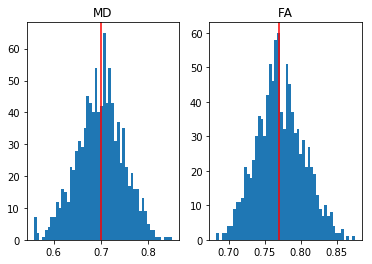

In [136]:
# noiseless signal generation
bval0 = 0
bval1 = 0.5
bval2 = 1.3
S0 = S_2comp(0, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_para = S_2comp(bval1, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_perp = S_2comp(bval1, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
S2_para = S_2comp(bval2, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S2_perp = S_2comp(bval2, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)

# optim init (S_other, sf_wm, D_para, D_perp)
x0 = np.array([0.75, 0.5, 1.0, 1.0])

# noise repetition
MDs = []
FAs = []
for i in range(Ntrial):
    # add noise with the right sigma
    S0_noisy = S0 + effective_sigma[0]*np.random.randn()
    S1_para_noisy = S1_para + effective_sigma[1]*np.random.randn()
    S1_perp_noisy = S1_perp + effective_sigma[1]*np.random.randn()
    S2_para_noisy = S2_para + effective_sigma[2]*np.random.randn()
    S2_perp_noisy = S2_perp + effective_sigma[2]*np.random.randn()    
    
    # estimate Diff
    data = np.array([S0_noisy, S1_para_noisy, S2_para_noisy, S1_perp_noisy, S2_perp_noisy])
                
    # error function
    def f(xdata):
        S0est, sf, Dpara, Dperp = xdata
        Swmpara = diff(np.array([0, bval1, bval2]), Dpara)
        Swmperp = diff(np.array([bval1, bval2]), Dperp)
        Swm = np.concatenate([Swmpara, Swmperp], axis=0)
        Scsf = diff(np.array([bval0, bval1, bval2, bval1, bval2]), Dcsf)
        S = S0est*(sf*Swm + (1-sf)*Scsf)
        return S - data

    sol = lsmin(f, x0, jac='2-point', bounds=((0, 0, 0, 0),(1, 1, 3, 3)), method='trf', ftol=1e-8, xtol=1e-8, gtol=1e-8, x_scale=1.0, loss='linear', f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, jac_sparsity=None, max_nfev=None, verbose=0, args=(), kwargs={})

    D_para_est = sol.x[2]
    D_perp_est = sol.x[3]
    
    # compute metrics
    MD_est = MD(D_para_est, D_perp_est)
    FA_est = FA(D_para_est, D_perp_est)
    
    # log values
    MDs.append(MD_est)
    FAs.append(FA_est)
    
MDs = np.array(MDs)
FAs = np.array(FAs)

pl.figure()
pl.subplot(1,2,1)
pl.hist(MDs, 50)
pl.axvline(WM_MD, c='red')
pl.title('MD')
pl.subplot(1,2,2)
pl.hist(FAs, 50)
pl.axvline(WM_FA, c='red')
pl.title('FA')
pl.show()

In [137]:
strat.append('fit 2-comp 2-shells (b 0 0.5 1.3)')
MD_bias.append(WM_MD - MDs.mean())
FA_bias.append(WM_FA - FAs.mean())
MD_std.append(MDs.std())
FA_std.append(FAs.std())

### case 4: Fitting 2-comp with 3 shell + b0

Signal from 2-comp model   
We simulate the signal for 22 b0 and 30 $b_{low}$, 60 $b_{mid}$ and 120 $b_{high}$   
We fit the 2-comp model on the 7 data point and use the Diffusivities from the WM compartement for metrics

In [138]:
# compute effective sigma
effective_sigma = compute_sigmas(sigma, np.array([6, 30, 60, 120]), np.array([1, 2, 2, 2]))
print(effective_sigma)

[0.00760376 0.00480904 0.00340051 0.00240452]


### 4.1   bval = (0, 0.5, 1.0, 1.5)

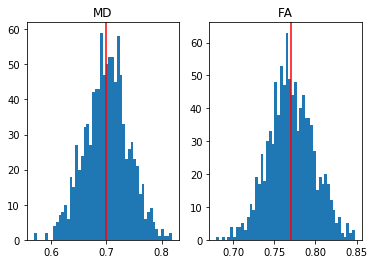

In [139]:
# noiseless signal generation
bval0 = 0
bval1 = 0.5
bval2 = 1.0
bval3 = 1.5
S0 = S_2comp(0, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_para = S_2comp(bval1, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_perp = S_2comp(bval1, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
S2_para = S_2comp(bval2, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S2_perp = S_2comp(bval2, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
S3_para = S_2comp(bval3, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S3_perp = S_2comp(bval3, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)

# optim init (S_other, sf_wm, D_para, D_perp)
x0 = np.array([0.75, 0.5, 1.0, 1.0])

# noise repetition
MDs = []
FAs = []
for i in range(Ntrial):
    # add noise with the right sigma
    S0_noisy = S0 + effective_sigma[0]*np.random.randn()
    S1_para_noisy = S1_para + effective_sigma[1]*np.random.randn()
    S1_perp_noisy = S1_perp + effective_sigma[1]*np.random.randn()
    S2_para_noisy = S2_para + effective_sigma[2]*np.random.randn()
    S2_perp_noisy = S2_perp + effective_sigma[2]*np.random.randn()    
    S3_para_noisy = S3_para + effective_sigma[3]*np.random.randn()
    S3_perp_noisy = S3_perp + effective_sigma[3]*np.random.randn()  
    
    # estimate Diff
    data = np.array([S0_noisy, S1_para_noisy, S2_para_noisy, S3_para_noisy,S1_perp_noisy, S2_perp_noisy, S3_perp_noisy])
                
    # error function
    def f(xdata):
        S0est, sf, Dpara, Dperp = xdata
        Swmpara = diff(np.array([0, bval1, bval2, bval3]), Dpara)
        Swmperp = diff(np.array([bval1, bval2, bval3]), Dperp)
        Swm = np.concatenate([Swmpara, Swmperp], axis=0)
        Scsf = diff(np.array([bval0, bval1, bval2, bval3, bval1, bval2, bval3]), Dcsf)
        S = S0est*(sf*Swm + (1-sf)*Scsf)
        return S - data

    sol = lsmin(f, x0, jac='2-point', bounds=((0, 0, 0, 0),(1, 1, 3, 3)), method='trf', ftol=1e-8, xtol=1e-8, gtol=1e-8, x_scale=1.0, loss='linear', f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, jac_sparsity=None, max_nfev=None, verbose=0, args=(), kwargs={})

    D_para_est = sol.x[2]
    D_perp_est = sol.x[3]
    
    # compute metrics
    MD_est = MD(D_para_est, D_perp_est)
    FA_est = FA(D_para_est, D_perp_est)
    
    # log values
    MDs.append(MD_est)
    FAs.append(FA_est)
    
MDs = np.array(MDs)
FAs = np.array(FAs)

pl.figure()
pl.subplot(1,2,1)
pl.hist(MDs, 50)
pl.axvline(WM_MD, c='red')
pl.title('MD')
pl.subplot(1,2,2)
pl.hist(FAs, 50)
pl.axvline(WM_FA, c='red')
pl.title('FA')
pl.show()

In [140]:
strat.append('fit 2-comp 3-shells (b 0 0.5 1.0 1.5)')
MD_bias.append(WM_MD - MDs.mean())
FA_bias.append(WM_FA - FAs.mean())
MD_std.append(MDs.std())
FA_std.append(FAs.std())

### 4.2   bval = (0, 0.3, 1.0, 1.25)

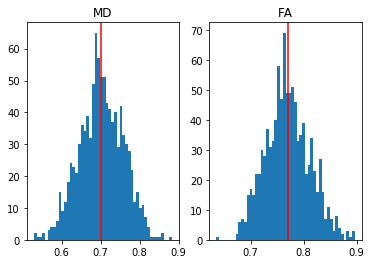

In [141]:
# noiseless signal generation
bval0 = 0
bval1 = 0.3
bval2 = 1.0
bval3 = 1.25
S0 = S_2comp(0, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_para = S_2comp(bval1, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_perp = S_2comp(bval1, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
S2_para = S_2comp(bval2, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S2_perp = S_2comp(bval2, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
S3_para = S_2comp(bval3, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S3_perp = S_2comp(bval3, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)

# optim init (S_other, sf_wm, D_para, D_perp)
x0 = np.array([0.75, 0.5, 1.0, 1.0])

# noise repetition
MDs = []
FAs = []
for i in range(Ntrial):
    # add noise with the right sigma
    S0_noisy = S0 + effective_sigma[0]*np.random.randn()
    S1_para_noisy = S1_para + effective_sigma[1]*np.random.randn()
    S1_perp_noisy = S1_perp + effective_sigma[1]*np.random.randn()
    S2_para_noisy = S2_para + effective_sigma[2]*np.random.randn()
    S2_perp_noisy = S2_perp + effective_sigma[2]*np.random.randn()    
    S3_para_noisy = S3_para + effective_sigma[3]*np.random.randn()
    S3_perp_noisy = S3_perp + effective_sigma[3]*np.random.randn()  
    
    # estimate Diff
    data = np.array([S0_noisy, S1_para_noisy, S2_para_noisy, S3_para_noisy,S1_perp_noisy, S2_perp_noisy, S3_perp_noisy])
                
    # error function
    def f(xdata):
        S0est, sf, Dpara, Dperp = xdata
        Swmpara = diff(np.array([0, bval1, bval2, bval3]), Dpara)
        Swmperp = diff(np.array([bval1, bval2, bval3]), Dperp)
        Swm = np.concatenate([Swmpara, Swmperp], axis=0)
        Scsf = diff(np.array([bval0, bval1, bval2, bval3, bval1, bval2, bval3]), Dcsf)
        S = S0est*(sf*Swm + (1-sf)*Scsf)
        return S - data

    sol = lsmin(f, x0, jac='2-point', bounds=((0, 0, 0, 0),(1, 1, 3, 3)), method='trf', ftol=1e-8, xtol=1e-8, gtol=1e-8, x_scale=1.0, loss='linear', f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, jac_sparsity=None, max_nfev=None, verbose=0, args=(), kwargs={})

    D_para_est = sol.x[2]
    D_perp_est = sol.x[3]
    
    # compute metrics
    MD_est = MD(D_para_est, D_perp_est)
    FA_est = FA(D_para_est, D_perp_est)
    
    # log values
    MDs.append(MD_est)
    FAs.append(FA_est)
    
MDs = np.array(MDs)
FAs = np.array(FAs)

pl.figure()
pl.subplot(1,2,1)
pl.hist(MDs, 50)
pl.axvline(WM_MD, c='red')
pl.title('MD')
pl.subplot(1,2,2)
pl.hist(FAs, 50)
pl.axvline(WM_FA, c='red')
pl.title('FA')
pl.show()

In [142]:
strat.append('fit 2-comp 3-shells (b 0 0.3 1.0 1.25)')
MD_bias.append(WM_MD - MDs.mean())
FA_bias.append(WM_FA - FAs.mean())
MD_std.append(MDs.std())
FA_std.append(FAs.std())

### 4.3 bval = (0, 0.3, 0.7, 1.3)

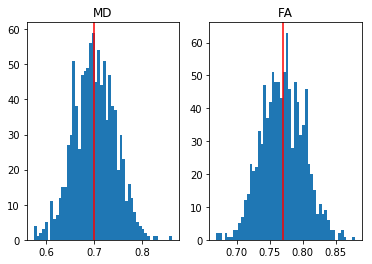

In [143]:
# noiseless signal generation
bval0 = 0
bval1 = 0.3
bval2 = 0.7
bval3 = 1.3
S0 = S_2comp(0, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_para = S_2comp(bval1, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_perp = S_2comp(bval1, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
S2_para = S_2comp(bval2, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S2_perp = S_2comp(bval2, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
S3_para = S_2comp(bval3, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S3_perp = S_2comp(bval3, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)

# optim init (S_other, sf_wm, D_para, D_perp)
x0 = np.array([0.75, 0.5, 1.0, 1.0])

# noise repetition
MDs = []
FAs = []
for i in range(Ntrial):
    # add noise with the right sigma
    S0_noisy = S0 + effective_sigma[0]*np.random.randn()
    S1_para_noisy = S1_para + effective_sigma[1]*np.random.randn()
    S1_perp_noisy = S1_perp + effective_sigma[1]*np.random.randn()
    S2_para_noisy = S2_para + effective_sigma[2]*np.random.randn()
    S2_perp_noisy = S2_perp + effective_sigma[2]*np.random.randn()    
    S3_para_noisy = S3_para + effective_sigma[3]*np.random.randn()
    S3_perp_noisy = S3_perp + effective_sigma[3]*np.random.randn()  
    
    # estimate Diff
    data = np.array([S0_noisy, S1_para_noisy, S2_para_noisy, S3_para_noisy,S1_perp_noisy, S2_perp_noisy, S3_perp_noisy])
                
    # error function
    def f(xdata):
        S0est, sf, Dpara, Dperp = xdata
        Swmpara = diff(np.array([0, bval1, bval2, bval3]), Dpara)
        Swmperp = diff(np.array([bval1, bval2, bval3]), Dperp)
        Swm = np.concatenate([Swmpara, Swmperp], axis=0)
        Scsf = diff(np.array([bval0, bval1, bval2, bval3, bval1, bval2, bval3]), Dcsf)
        S = S0est*(sf*Swm + (1-sf)*Scsf)
        return S - data

    sol = lsmin(f, x0, jac='2-point', bounds=((0, 0, 0, 0),(1, 1, 3, 3)), method='trf', ftol=1e-8, xtol=1e-8, gtol=1e-8, x_scale=1.0, loss='linear', f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, jac_sparsity=None, max_nfev=None, verbose=0, args=(), kwargs={})

    D_para_est = sol.x[2]
    D_perp_est = sol.x[3]
    
    # compute metrics
    MD_est = MD(D_para_est, D_perp_est)
    FA_est = FA(D_para_est, D_perp_est)
    
    # log values
    MDs.append(MD_est)
    FAs.append(FA_est)
    
MDs = np.array(MDs)
FAs = np.array(FAs)

pl.figure()
pl.subplot(1,2,1)
pl.hist(MDs, 50)
pl.axvline(WM_MD, c='red')
pl.title('MD')
pl.subplot(1,2,2)
pl.hist(FAs, 50)
pl.axvline(WM_FA, c='red')
pl.title('FA')
pl.show()

In [144]:
strat.append('fit 2-comp 3-shells (b 0 0.3 0.7 1.3)')
MD_bias.append(WM_MD - MDs.mean())
FA_bias.append(WM_FA - FAs.mean())
MD_std.append(MDs.std())
FA_std.append(FAs.std())

# Summary of all methods

In [145]:
# list all strategies
for i in range(len(strat)):
    print('{}: {}'.format(i, strat[i]))

0: Baseline without csf (b1)
1: ignore csf (b1)
2: assume attenuated csf (b 0.5 1.0)
3: assume attenuated csf (b 0.5 1.5)
4: assume attenuated csf (b 0.75 1.5)
5: assume attenuated csf (b 0.75 1.25)
6: fit 2-comp 2-shells (b 0 0.5 1.0)
7: fit 2-comp 2-shells (b 0 0.5 1.5)
8: fit 2-comp 2-shells (b 0 0.75 1.0)
9: fit 2-comp 2-shells (b 0 0.3 1.0)
10: fit 2-comp 2-shells (b 0 0.5 1.3)
11: fit 2-comp 3-shells (b 0 0.5 1.0 1.5)
12: fit 2-comp 3-shells (b 0 0.3 1.0 1.25)
13: fit 2-comp 3-shells (b 0 0.3 0.7 1.3)


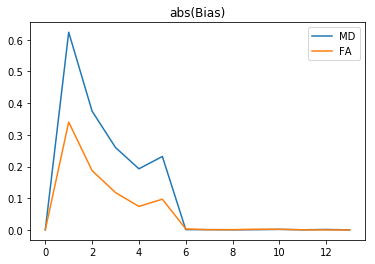

In [146]:
pl.figure()
pl.title('abs(Bias)')
pl.plot(np.abs(MD_bias), label='MD')
pl.plot(np.abs(FA_bias), label='FA')
pl.legend()
pl.show()

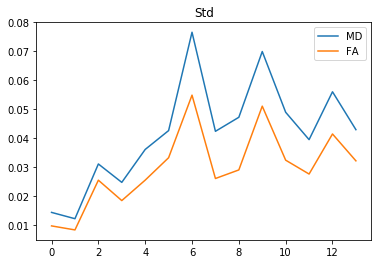

In [147]:
pl.figure()
pl.title('Std')
pl.plot(MD_std, label='MD')
pl.plot(FA_std, label='FA')
pl.legend()
pl.show()

# !!!!! Experimental non-sense past this point !!!!!

### Situation 1: 1-compartement single shell model
"Normal" case where we assumes no CSF contamination  
Acquire b0 and b1  
We estimate diffusivities from the b0 normalized signal ($E(b, \text{TE}) = \frac{S(b, \text{TE})}{S(0, \text{TE})}$)

In [54]:
# signal generation and normalization
bval = 1.0
S0 = S_2comp(0, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_para = S_2comp(bval, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
S1_perp = S_2comp(bval, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
E_para = S1_para / S0
E_perp = S1_perp / S0

In [57]:
# diffusivity estimation
D_para_est = np.log(E_para)/(-bval)
print(D_para_est)
D_perp_est = np.log(E_perp)/(-bval)
print(D_perp_est)

1.9894189801750646
0.9249193486789349


In [59]:
# estimated metrics
# MD
MD_est = MD(D_para_est, D_perp_est)
print('MD: GT = {:.3f}   est = {:.3f}   |err| = {:.3f}'.format(WM_MD, MD_est, np.abs(WM_MD - MD_est)))

# FA
FA_est = FA(D_para_est, D_perp_est)
print('FA: GT = {:.3f}   est = {:.3f}   |err| = {:.3f}'.format(WM_FA, FA_est, np.abs(WM_FA - FA_est)))

MD: GT = 0.700   est = 1.280   |err| = 0.580
FA: GT = 0.770   est = 0.447   |err| = 0.323


### Situation 2: fake 2-compartement where we assume full attenuation of csf
We choose a higher b than b0 for signal normalization and we assumes full attenuation of csf.  
2.1 Acquire b0.5 and b1  
2.2 Acquire b0.5 and b1.5  
2.3 Acquire b0.75 and b1.25  
2.4 Acquire b0.75 and b1.5  


In [63]:
# signal generation and normalization
bval0 = 0.5
bval1 = 1.0

for (bval0, bval1) in [(0.5, 1), (0.5, 1.5), (0.75, 1.25), (0.75, 1.5)]:
    print('\nbvals = {:.2f} {:.2f}'.format(bval0, bval1))
    
    S0_para = S_2comp(bval0, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
    S0_perp = S_2comp(bval0, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
    S1_para = S_2comp(bval1, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
    S1_perp = S_2comp(bval1, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
    E_para = S1_para / S0_para
    E_perp = S1_perp / S0_perp

    # diffusivity estimation
    D_para_est = np.log(E_para)/(bval0-bval1)
#     print(D_para_est)
    D_perp_est = np.log(E_perp)/(bval0-bval1)
#     print(D_perp_est)

    # estimated metrics
    # MD
    MD_est = MD(D_para_est, D_perp_est)
    print('MD: GT = {:.3f}   est = {:.3f}   |err| = {:.3f}'.format(WM_MD, MD_est, np.abs(WM_MD - MD_est)))

    # FA
    FA_est = FA(D_para_est, D_perp_est)
    print('FA: GT = {:.3f}   est = {:.3f}   |err| = {:.3f}'.format(WM_FA, FA_est, np.abs(WM_FA - FA_est)))


bvals = 0.50 1.00
MD: GT = 0.700   est = 1.042   |err| = 0.342
FA: GT = 0.770   est = 0.599   |err| = 0.171

bvals = 0.50 1.50
MD: GT = 0.700   est = 0.936   |err| = 0.236
FA: GT = 0.770   est = 0.661   |err| = 0.109

bvals = 0.75 1.25
MD: GT = 0.700   est = 0.911   |err| = 0.211
FA: GT = 0.770   est = 0.682   |err| = 0.088

bvals = 0.75 1.50
MD: GT = 0.700   est = 0.874   |err| = 0.174
FA: GT = 0.770   est = 0.703   |err| = 0.067


### Situation 3: fitting 2-compartement from 3-shell
3.1 We acquire b0, b0.5 and b1  
3.2 We acquire b0, b0.5 and b1.5  
We fit 2 WM diffusivity and 1 "signal" fraction from the data

In [104]:
# assumes data = (S(b_0), S(b_1_para), S(b_2_para), S(b_1_perp), S(b_2_perp))
# and param = (sf, Dpara, Dperp)
# wrap everything inside function for optimization

GT_x = np.array([sf1(TE, T2wm, T2csf, fwm), Dwmpara, Dwmperp])

In [161]:
x0 = np.array([0.5, 1.0, 1.0])
# code assumes bval0 is actually 0, without a para and a perp
for (bval0, bval1, bval2) in [(0, 0.5, 1), (0, 0.5, 1.5)]:
    print('\nbvals = {:.2f} {:.2f} {:.2f}'.format(bval0, bval1, bval2))
    
    S0 = S_2comp(bval0, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
    S1_para = S_2comp(bval1, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
    S1_perp = S_2comp(bval1, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
    S2_para = S_2comp(bval2, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
    S2_perp = S_2comp(bval2, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)

    # S0 = 1 is assumed and known
    data = np.array([S0, S1_para, S2_para, S1_perp, S2_perp])/S0

    def f(xdata):
        sf, Dpara, Dperp = xdata
        Swmpara = diff(np.array([bval0, bval1, bval2]), Dpara)
        Swmperp = diff(np.array([bval1, bval2]), Dperp)
        Swm = np.concatenate([Swmpara, Swmperp], axis=0)
        Scsf = diff(np.array([bval0, bval1, bval2, bval1, bval2]), Dcsf)
        S = sf*Swm + (1-sf)*Scsf
        return S - data
    
    sol = lsmin(f, x0, jac='2-point', bounds=((0, 0, 0),(1, 3, 3)), method='trf', ftol=1e-8, xtol=1e-8, gtol=1e-8, x_scale=1.0, loss='linear', f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, jac_sparsity=None, max_nfev=None, verbose=0, args=(), kwargs={})
    
    D_para_est = sol.x[1]
    D_perp_est = sol.x[2]

    # estimated metrics
    # MD
    MD_est = MD(D_para_est, D_perp_est)
    print('MD: GT = {:.3f}   est = {:.3f}   |err| = {:.3f}'.format(WM_MD, MD_est, np.abs(WM_MD - MD_est)))

    # FA
    FA_est = FA(D_para_est, D_perp_est)
    print('FA: GT = {:.3f}   est = {:.3f}   |err| = {:.3f}'.format(WM_FA, FA_est, np.abs(WM_FA - FA_est)))


bvals = 0.00 0.50 1.00
MD: GT = 0.700   est = 0.700   |err| = 0.000
FA: GT = 0.770   est = 0.770   |err| = 0.000

bvals = 0.00 0.50 1.50
MD: GT = 0.700   est = 0.700   |err| = 0.000
FA: GT = 0.770   est = 0.770   |err| = 0.000


### Now with noise and S0 estimation
We compare b = [0, 0.5, 1.5] and b = [0, 0.3, 1.0, 1.5] at equivalent SNR

In [162]:
# code assumes bval0 is actually 0, without a para and a perp
Ntrial = 500
SNRs = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]
MDss = []
FAss = []
paramss = []
for SNR in SNRs:
    MDs = []
    FAs = []
    params = []
    for i in range(Ntrial):
#         for (bval0, bval1, bval2) in [(0, 0.5, 1)]:
        for (bval0, bval1, bval2) in [(0, 0.5, 1.5)]:
    #         print('\nbvals = {:.2f} {:.2f} {:.2f}'.format(bval0, bval1, bval2))

            S0 = S_2comp(bval0, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
            S1_para = S_2comp(bval1, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
            S1_perp = S_2comp(bval1, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
            S2_para = S_2comp(bval2, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
            S2_perp = S_2comp(bval2, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)

            data = np.array([S0, S1_para, S2_para, S1_perp, S2_perp])
            data += (1/SNR)*np.random.randn(data.shape[0])

            x0 = np.array([0.75, 0.5, 1.0, 1.0])
            
            def f(xdata):
                S0est, sf, Dpara, Dperp = xdata
                Swmpara = diff(np.array([bval0, bval1, bval2]), Dpara)
                Swmperp = diff(np.array([bval1, bval2]), Dperp)
                Swm = np.concatenate([Swmpara, Swmperp], axis=0)
                Scsf = diff(np.array([bval0, bval1, bval2, bval1, bval2]), Dcsf)
                S = S0est*(sf*Swm + (1-sf)*Scsf)
                return S - data

            sol = lsmin(f, x0, jac='2-point', bounds=((0, 0, 0, 0),(1, 1, 3, 3)), method='trf', ftol=1e-8, xtol=1e-8, gtol=1e-8, x_scale=1.0, loss='linear', f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, jac_sparsity=None, max_nfev=None, verbose=0, args=(), kwargs={})

            params.append(sol.x)
            D_para_est = sol.x[2]
            D_perp_est = sol.x[3]

            # estimated metrics
            # MD
            MD_est = MD(D_para_est, D_perp_est)
            MDs.append(MD_est)
    #         print('MD: GT = {:.3f}   est = {:.3f}   |err| = {:.3f}'.format(WM_MD, MD_est, np.abs(WM_MD - MD_est)))

            # FA
            FA_est = FA(D_para_est, D_perp_est)
            FAs.append(FA_est)
    #         print('FA: GT = {:.3f}   est = {:.3f}   |err| = {:.3f}'.format(WM_FA, FA_est, np.abs(WM_FA - FA_est)))
    paramss.append(params)
    MDss.append(MDs)
    FAss.append(FAs)

In [165]:
MD_est1 = np.array(MDss)
FA_est1 = np.array(FAss)

# for isnr, SNR in enumerate(SNRs):
#     print('SNR = {}'.format(SNR))
#     pl.figure()
#     pl.subplot(1,2,1)
#     pl.hist(MD_est[isnr,:], 20)
#     pl.axvline(WM_MD, c='red')
#     pl.title('MD')
#     pl.subplot(1,2,2)
#     pl.hist(FA_est[isnr,:], 20)
#     pl.axvline(WM_FA, c='red')
#     pl.title('FA')
#     pl.show()

### Now with an extra shell

In [164]:
# code assumes bval0 is actually 0, without a para and a perp
Ntrial = 500
SNRs2 = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]
SNRs2 = list((np.sqrt(5/7))*np.array(SNRs2)) # compensation for 7 datapoints instead of 5
MDss2 = []
FAss2 = []
paramss2 = []
for SNR in SNRs2:
    MDs = []
    FAs = []
    params = []
    for i in range(Ntrial):
        for (bval0, bval1, bval2, bval3) in [(0, 0.3, 1.0, 1.5)]:
    #         print('\nbvals = {:.2f} {:.2f} {:.2f}'.format(bval0, bval1, bval2))

            S0 = S_2comp(bval0, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
            S1_para = S_2comp(bval1, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
            S1_perp = S_2comp(bval1, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
            S2_para = S_2comp(bval2, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
            S2_perp = S_2comp(bval2, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)
            S3_para = S_2comp(bval3, TE, fwm, Dwmpara, Dcsf, T2wm, T2csf)
            S3_perp = S_2comp(bval3, TE, fwm, Dwmperp, Dcsf, T2wm, T2csf)

            data = np.array([S0, S1_para, S2_para, S3_para, S1_perp, S2_perp, S3_perp])
            data += (1/SNR)*np.random.randn(data.shape[0])

            x0 = np.array([0.75, 0.5, 1.0, 1.0])
            
            def f(xdata):
                S0est, sf, Dpara, Dperp = xdata
                Swmpara = diff(np.array([bval0, bval1, bval2, bval3]), Dpara)
                Swmperp = diff(np.array([bval1, bval2, bval3]), Dperp)
                Swm = np.concatenate([Swmpara, Swmperp], axis=0)
                Scsf = diff(np.array([bval0, bval1, bval2, bval3, bval1, bval2, bval3]), Dcsf)
                S = S0est*(sf*Swm + (1-sf)*Scsf)
                return S - data

            sol = lsmin(f, x0, jac='2-point', bounds=((0, 0, 0, 0),(1, 1, 3, 3)), method='trf', ftol=1e-8, xtol=1e-8, gtol=1e-8, x_scale=1.0, loss='linear', f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, jac_sparsity=None, max_nfev=None, verbose=0, args=(), kwargs={})

            params.append(sol.x)
            D_para_est = sol.x[2]
            D_perp_est = sol.x[3]

            # estimated metrics
            # MD
            MD_est = MD(D_para_est, D_perp_est)
            MDs.append(MD_est)
    #         print('MD: GT = {:.3f}   est = {:.3f}   |err| = {:.3f}'.format(WM_MD, MD_est, np.abs(WM_MD - MD_est)))

            # FA
            FA_est = FA(D_para_est, D_perp_est)
            FAs.append(FA_est)
    #         print('FA: GT = {:.3f}   est = {:.3f}   |err| = {:.3f}'.format(WM_FA, FA_est, np.abs(WM_FA - FA_est)))
    paramss2.append(params)
    MDss2.append(MDs)
    FAss2.append(FAs)

In [158]:
# MD_est2 = np.array(MDss2)
# FA_est2 = np.array(FAss2)

# for isnr, SNR in enumerate(SNRs):
#     print('SNR = {}'.format(SNR))
#     pl.figure()
#     pl.subplot(1,2,1)
#     pl.hist(MD_est[isnr,:], 20)
#     pl.axvline(WM_MD, c='red')
#     pl.title('MD')
#     pl.subplot(1,2,2)
#     pl.hist(FA_est[isnr,:], 20)
#     pl.axvline(WM_FA, c='red')
#     pl.title('FA')
#     pl.show()

SNR = 10 (8.5)


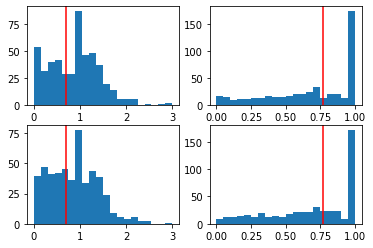

SNR = 50 (42.3)


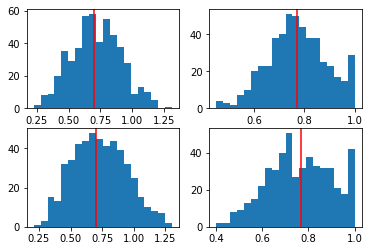

SNR = 100 (84.5)


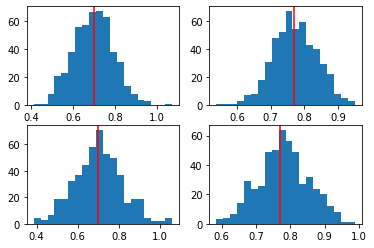

SNR = 500 (422.6)


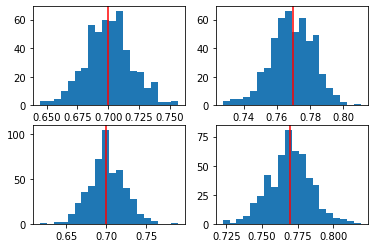

SNR = 1000 (845.2)


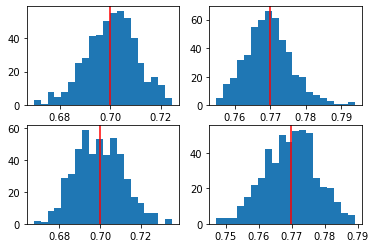

SNR = 5000 (4225.8)


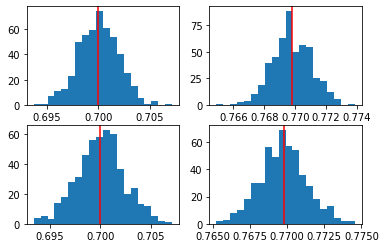

SNR = 10000 (8451.5)


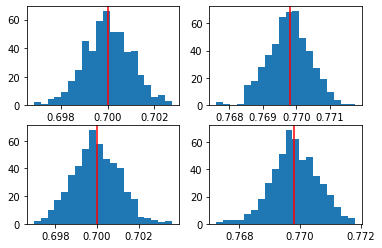

SNR = 50000 (42257.7)


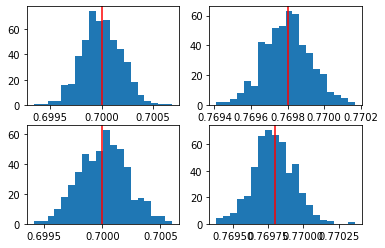

SNR = 100000 (84515.4)


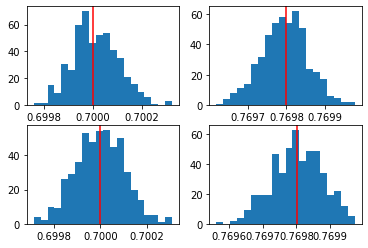

In [166]:
MD_est2 = np.array(MDss2)
FA_est2 = np.array(FAss2)

for isnr, SNR in enumerate(SNRs):
    print('SNR = {} ({:.1f})'.format(SNR, SNRs2[isnr]))
    pl.figure()
    pl.subplot(2,2,1)
    pl.hist(MD_est1[isnr,:], 20)
    pl.axvline(WM_MD, c='red')
#     pl.title('MD 2shells')
    pl.subplot(2,2,2)
    pl.hist(FA_est1[isnr,:], 20)
    pl.axvline(WM_FA, c='red')
#     pl.title('FA 2shells')
    pl.subplot(2,2,3)
    pl.hist(MD_est2[isnr,:], 20)
    pl.axvline(WM_MD, c='red')
#     pl.title('MD 3shells')
    pl.subplot(2,2,4)
    pl.hist(FA_est2[isnr,:], 20)
    pl.axvline(WM_FA, c='red')
#     pl.title('FA 3shells')
    pl.show()

In [177]:
# SNR realist for 5volume simulation assuming 200 total volume
30/trans(TE, T2wm)*np.sqrt(200/5)

455.15458509852044